In [16]:
import collections
import itertools
import math

import numpy as np
import numba
import pandas as pd
import scipy.stats as st
import requests

import emcee
import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

# Shubhi Does Data: The First Post's First Draft

### The Question
Are there a dearth of prime-aged, quality center defensive midfielders *(CDM)* in the game right now? Many *CDMs* are young and upcoming (**Emre Can**, **N'golo Kante**, **Casemiro**, **Julian Weigl**, etc.) and many are much older (**Xabi Alonso**, **Yaya Toure**, **Javier Mascherano**, etc.), but from an inuitive standpoint, it feels as if there are very few that are of prime age: between 26 and 30. It's become pretty apparent lately seeing that FC Barcelona, FC Bayern Munich, Manchester United, and others have an arguably shaky defensive midfield. Let's see if we can answer this question across 11 European Leagues (Austrian, Belgian, English, French, German, Italian, Duth, Portuguese, Scottish, Spanish, & Turkish) and maybe even why this is the case if so, with some data.

### The Approach
This is a pretty interesting problem with a lot of components. We'll try to break down each part and answer each one as solidly as possible.

**1.** What is the age distribution among *CDMs*? We'll use FIFA data to answer this. Ignoring the factor of quality, are there just more younger *CDMs* than prime or older ones? We'll compare this with the age distribution of previous years as a control to see if CDMs now have an unusually small number of `prime` players now, or not. We'll separate the age groups into: 

  | Group | Ages |
  |-------|-------|
  | Kids  | < 20 |
  | Youth | 20-25 |
  | Prime | 26-30 |
  | Old   | > 30 |

**2.** What defines a quality center defensive midfielder? We'll use FIFA data to determine features to see what characteristics are viewed as valuable for a *CDM*. We can perform correlation analysis on features and the ultimate FIFA rating of players to determine this. From this, we'll use real world data to determine which players really play well as a *CDM* now, and over the years. The reason we use real world data, instead of simply leveraging the FIFA data is that FIFA data doesn't accurately reflect actual gameplay in regards to the current season, instead taking previous seasons and gameplay overall into account. We want to be as accurate as possible when qualifying a player as quality or not. We can then compare this back to the initial age distribution to see how the distribution of quality vs. non-quality players stack up, when compared to age.

**3.** Lastly, we'll try to explain any results, if we can.

#### 1. CDM Age Distribution

I imported the FIFA *CDM* data via [sofifa.com](http://sofifa.com). I used [import.io](http://import.io) to scrape the data and put it into a tidy csv file.

In [18]:
# Import data
df_fifa_cdm = pd.read_csv('data/fifa_17_cdm_data.csv')
df_fifa_cdm.head()

,player_url,age/_source,position/_source,value/_source,position/_text,player_url/_title,player_url/_source,player_url/_text,name,value/_currency,overall,position,value,overall/_source,age,pageUrl
0,http://sofifa.com/player/189511,27,/players?pn=10,€ 41.5,CDM,Sergio Busquets Burgos,/player/189511,Sergio Busquets,Sergio Busquets,EUR,87; 88,http://sofifa.com/players?pn=10,41.5,87; 88,27,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
1,http://sofifa.com/player/170890,29,/players?pn=10; /players?pn=14,€ 29.5,CDM; CM,Blaise Matuidi,/player/170890,B. Matuidi,B. Matuidi,EUR,86; 86,http://sofifa.com/players?pn=10; http://sofifa...,29.5,86; 86,29,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
2,http://sofifa.com/player/45197,34,/players?pn=10; /players?pn=14,€ 9,CDM; CM,Xabier Alonso Olano,/player/45197,Xabi Alonso,Xabi Alonso,EUR,84; 84,http://sofifa.com/players?pn=10; http://sofifa...,9.0,84; 84,34,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
3,http://sofifa.com/player/191202,27,/players?pn=10,€ 24,CDM,Nemanja Matić,/player/191202,N. Matić,N. Matić,EUR,84; 84,http://sofifa.com/players?pn=10,24.0,84; 84,27,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
4,http://sofifa.com/player/197242,26,/players?pn=10,€ 28.5,CDM,Grzegorz Krychowiak,/player/197242,G. Krychowiak,G. Krychowiak,EUR,84; 86,http://sofifa.com/players?pn=10,28.5,84; 86,26,http://sofifa.com/players?gender=0&lg%5B0%5D=8...


Well, I thought the data was already tidy, but looking at it again, it doesn't seem to be. We have a lot of unnecessary columns. Let's go ahead and tidy it up.

In [19]:
# Let's first label the columns.
df_fifa_cdm.columns = ['player_url', 'age', 'position_url', 'value_euros', 'positions', 'player_name',
                       'player_source', 'player_url_text', 'name', 'currency', 'overall_rating',
                       'full_position_url', 'value', 'overall_again', 'age_again', 'page_url']
# And then we can drop the unnecessary columns.
df_fifa_cdm = df_fifa_cdm.drop(['position_url', 'value_euros', 'player_url_text', 'player_source',
                                'name','currency', 'overall_again', ''
                                'full_position_url', 'age_again'], axis=1)
df_fifa_cdm.head()

,player_url,age,positions,player_name,overall_rating,value,page_url
0,http://sofifa.com/player/189511,27,CDM,Sergio Busquets Burgos,87; 88,41.5,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
1,http://sofifa.com/player/170890,29,CDM; CM,Blaise Matuidi,86; 86,29.5,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
2,http://sofifa.com/player/45197,34,CDM; CM,Xabier Alonso Olano,84; 84,9.0,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
3,http://sofifa.com/player/191202,27,CDM,Nemanja Matić,84; 84,24.0,http://sofifa.com/players?gender=0&lg%5B0%5D=8...
4,http://sofifa.com/player/197242,26,CDM,Grzegorz Krychowiak,84; 86,28.5,http://sofifa.com/players?gender=0&lg%5B0%5D=8...


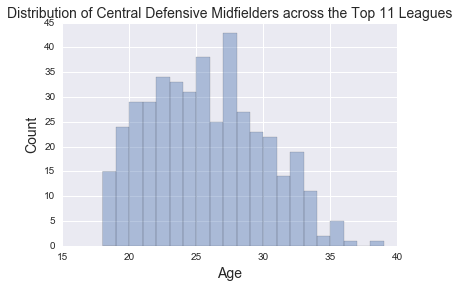

In [36]:
# Ah, much tidier to deal with. Let's plot the age distribution for these CDMs
sns.distplot(df_fifa_cdm['age'], kde=False, bins=max(df_fifa_cdm['age']) - min(df_fifa_cdm['age']), axlabel="Age")
plt.title("Distribution of Central Defensive Midfielders across the Top 11 Leagues")
plt.ylabel("Count")

This distribution tells us that a decent number of *CDMs* are kids or youth, but there is no signifcant drop off after the young age group, as we intuitively assumed. This makes answering our overall question a little easier. Still, we have to remember that we're thinking about this question about lack of prime, quality *CDMs*. In this scenario, the qualifier "lack" is relative. Therefore, we have to compare this to what the distribution looks like compared to previous years.

Another thing to note overall is this seems to be a a relatively normal distribution with a slight tail in the older players.

Before we start looking at the distribution of previous years, I also want to take a look at the distribution amongst the age groups we defined above. As a reminder, here they are again:

  | Group | Ages |
  |-------|-------|
  | Kids  | < 20 |
  | Youth | 20-25 |
  | Prime | 26-30 |
  | Old   | > 30 |


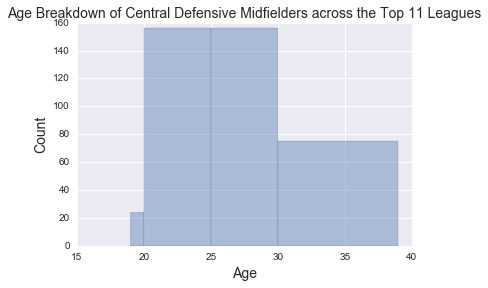

In [38]:
sns.distplot(df_fifa_cdm['age'], kde=False, bins=[19, 20, 25, 30, 39], axlabel="Age")
plt.ylabel("Count")
plt.title("Age Breakdown of Central Defensive Midfielders across the Top 11 Leagues")

From this 4-bin histogram, we can see pretty clearly that there most definitely isn't a lack of center defensive midfielders in this `prime` age group. Now that we've looked at the age distribution for *CDMs* now, let's look at previous years and see if a trend follows. We'll go back 10 seasons to see this age distribution trend.

In [45]:
# Let's clean up all of the data for all of the years of FIFA data that we have.

# First define the filenames
filenames = ['data/fifa_16_cdm_data.csv', 'data/fifa_15_cdm_data.csv', 'data/fifa_14_cdm_data.csv',
             'data/fifa_13_cdm_data.csv', 'data/fifa_12_cdm_data.csv', 'data/fifa_11_cdm_data.csv',
             'data/fifa_10_cdm_data.csv', 'data/fifa_09_cdm_data.csv', 'data/fifa_08_cdm_data.csv',
             'data/fifa_07_cdm_data.csv']

# Import all years
df_fifa_yr_cdms = [pd.read_csv(f) for f in filenames]

# Clean up columns for all years
for df in df_fifa_yr_cdms:
    df.columns = ['player_url', 'age', 'position_url', 'value_euros', 'positions', 'player_name',
                       'player_source', 'player_url_text', 'name', 'currency', 'overall_rating',
                       'full_position_url', 'value', 'overall_again', 'age_again', 'page_url']
    # And then we can drop the unnecessary columns.
    df.drop(['position_url', 'value_euros', 'player_url_text', 'player_source',
             'name','currency', 'overall_again', ''
             'full_position_url', 'age_again'], axis=1, inplace=True)

# Insert FIFA 17 data
df_fifa_yr_cdms = [df_fifa_cdm] + df_fifa_yr_cdms

I think the best way to view the variation of age group distribution over time is via a line graph. It will allow us to see the breakdown in terms of the 4 age groups.

In [51]:
def age_distribution(age):
    '''
    Return age distribution for four age groups, normalized by number of players in that position.
    '''
    kids = len(filter(lambda val: val < 20, age))
    young = len(filter(lambda val: val < 26 and val > 20, age))
    prime = len(filter(lambda val: val < 31 and val > 25, age))
    old = len(filter(lambda val: val > 30, age))
    count = float(len(age))
    return np.array([kids/count, young/count, prime/count, old/count])

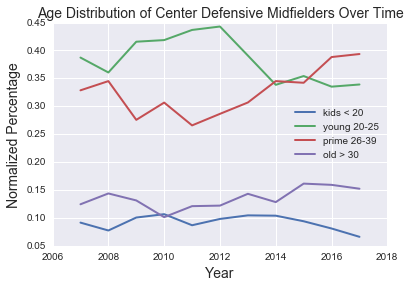

In [63]:
age_distribution_over_time = np.array([age_distribution(df['age']) for df in df_fifa_yr_cdms])
plt.plot(range(2007, 2018), age_distribution_over_time)
plt.title('Age Distribution of Center Defensive Midfielders Over Time')
plt.xlabel('Year')
plt.ylabel('Normalized Percentage')
plt.legend(('kids < 20', 'young 20-25', 'prime 26-39', 'old > 30'), loc='center right')

This graph tells us some really interesting info about the age distribution. We see that there are a great deal of "young" *CDMs* from 2007 to 2013, but actually most recently, the 